In [1]:
%matplotlib inline
# %matplotlib

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

<function matplotlib.pyplot.show(*args, **kw)>

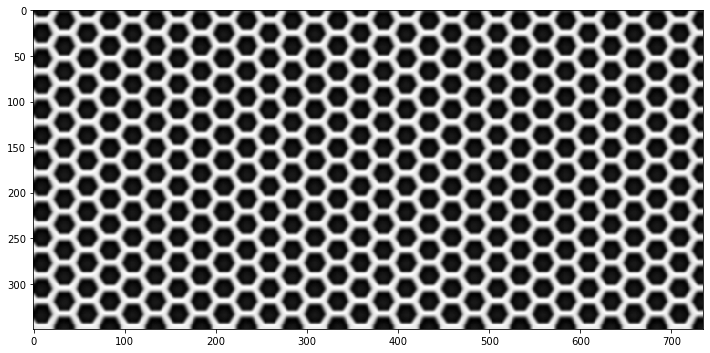

In [2]:
img = cv.imread('metalgrid.jpg')
imGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Suavizado Gaussiano para reducir el ruido solo donde no hay bordes
#===================================================================
imGray = cv.GaussianBlur(imGray,(7,7),0)
# Dado el gran ruido de la imagen fue necesario agrandar
# el kernel a 7*7

plt.imshow(imGray, cmap='gray')
plt.show

Aplicamos Sobel en x e y para luego calcular el módulo y las direcciones

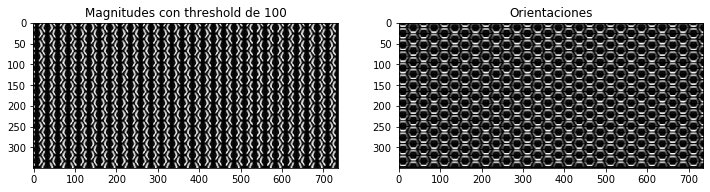

In [3]:
# Aplicamos Sobelx en 'float32' y luego convertimos de nuevo a 8-bit para evitar overflow
sobelx_64 = cv.Sobel(imGray,cv.CV_32F,1,0,ksize=3)
absx_64 = np.absolute(sobelx_64)
sobelx_8u1 = absx_64/absx_64.max()*255
sobelx_8u = np.uint8(sobelx_8u1)

# De igual modo para Sobely
sobely_64 = cv.Sobel(imGray,cv.CV_32F,0,1,ksize=3)
absy_64 = np.absolute(sobely_64)
sobely_8u1 = absy_64/absy_64.max()*255
sobely_8u = np.uint8(sobely_8u1)
plt.subplot(121)
plt.imshow(sobelx_8u, 'gray')
plt.title("Magnitudes con threshold de 100")
#plt.show()
plt.subplot(122)

#plt.figure()
plt.imshow(sobely_8u, 'gray')
plt.title("Orientaciones")
plt.show()

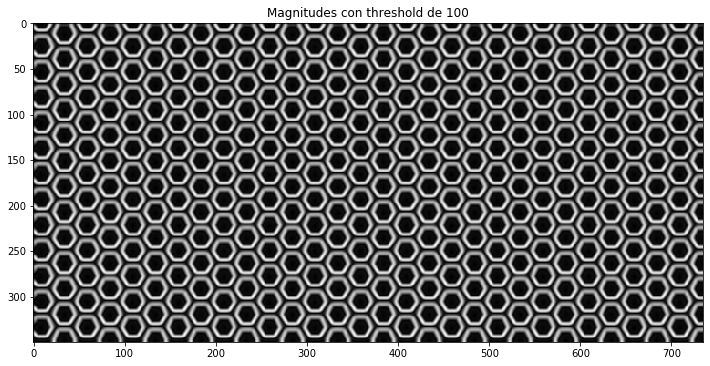

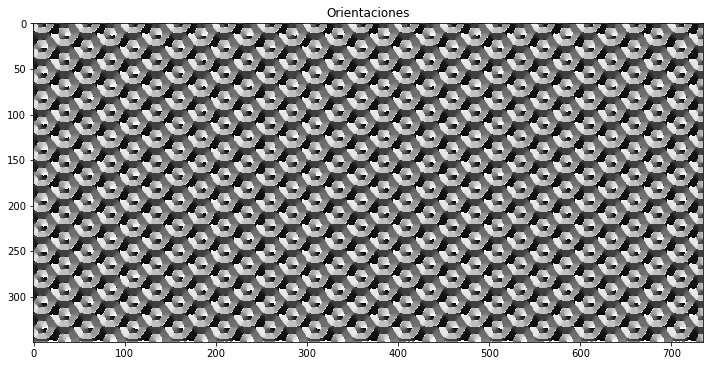

In [4]:
# De los gradiente calculamos Magnitud y lo pasamos a 8-bit (Opcional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)

# Encontramos la Dirección y la pasamos a grados
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)

plt.imshow(mag, 'gray')
plt.title("Magnitudes con threshold de 100")
plt.show()
plt.figure()
plt.imshow(angle, 'gray')
plt.title("Orientaciones")
plt.show()

In [5]:
# Supresión de no-máximos
#========================

# Encontramos los píxels vecinos (b,c) en la dirección (redondeadea) del gradiente y aplicamos la supresión de no-máximos
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)

for i in range(1,M-1):
    for j in range(1,N-1):
        # Guardo en b y c los elementos vecinos para despues hacer la supresión.
       # Horizontal 0
        #if (-22.5 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] < -157.5):
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Supresión de no-máximos
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0

print('No-máximos')


No-máximos


In [6]:
# Umbralizado por histéresis
#===========================
UmbralAlto = 21
UmbralBajo = 15

M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)

# Si la intensidad de un borde es mayor a 'UmbralAlto' es seguro un umbral, debajo de 'UmbralBajo' seguro no es
strong_i, strong_j = np.where(Non_max >= UmbralAlto)
zeros_i, zeros_j = np.where(Non_max < UmbralBajo)

# Bordes débiles
weak_i, weak_j = np.where((Non_max <= UmbralAlto) & (Non_max >= UmbralBajo))

# Setear el mismo valor a todos los tipos de píxel
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

print('Histéresis')

Histéresis


Armado imagen bordes
Terminó


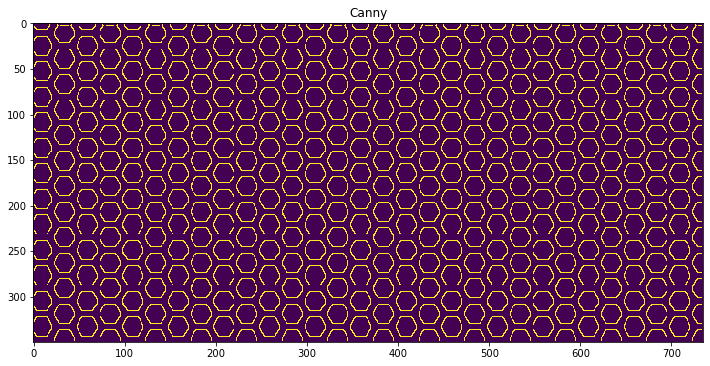

In [7]:
# Armo la imagen de bordes
#=========================
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

print('Armado imagen bordes')

# Muestro la imagen
#==================
#cv.imshow("Canny",out)
plt.figure()
plt.title("Canny")
plt.imshow(out)
print("Terminó")

Termino


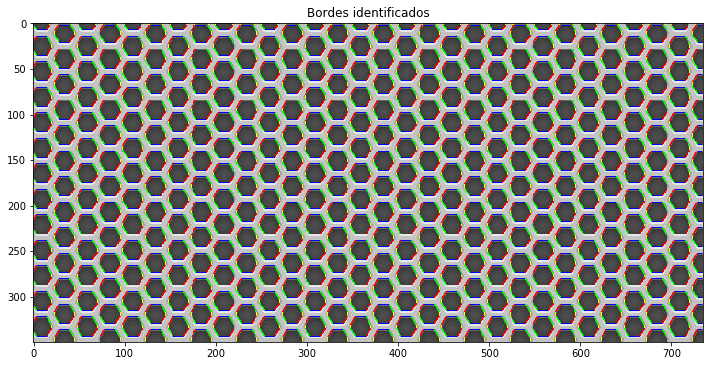

In [14]:
# Colorear los bordes
#====================
M, N, l = img.shape
img2= cv.imread('metalgrid.jpg')
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

for i in range(1,M-1):
    for j in range(1, N-1):
        # Si, el angulo en angle[i,j] es X pintar el pixel ij en X color
        if (out[i,j] == 255):
            # Diagonal 45 - Rojo
            if((22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5)):
                img2[i,j, :] = [255, 0, 0]                
            # Diagonal 135 - Verde
            elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
                img2[i,j, :] = [0, 255, 0]
            # Horizontal 0 - Azul
            elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
                img2[i,j, :] = [0, 0, 255]
                #img2[i+1,j, :] = [0, 0, 255]
                #img2[i-1,j, :] = [0, 0, 255]
                
            # Vertical 90 - Amarillo
            elif (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
                img2[i,j, :] = [255, 255, 0]
            
plt.figure()
plt.title("Bordes identificados")
plt.imshow(img2)
print("Termino")